In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

In [3]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets.copy() 
  
# metadata 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata) 
  
# variable information 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables) 



{'uci_id': 544, 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Sep 10 2024', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'ID': 358, 'type': 

In [ ]:
x_tr, x_te, y_tr, y_te = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

torch.Size([1477, 23])

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [5]:
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC','CALC','MTRANS']
# One-hot encode categorical features, dropping the first category
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})

# Convert X_encoded to a PyTorch tensor
X_tensor = torch.tensor(X_encoded.values, dtype=torch.float32)
X_tensor.shape

torch.Size([2111, 23])

In [15]:
y['NObeyesdad'] = y['NObeyesdad'].astype('category').cat.codes

# Convert to tensor
y_tensor = torch.tensor(y['NObeyesdad'].to_numpy(), dtype=torch.long)
x_tr, x_te, y_tr, y_te = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

#try standardising
x_mean, x_std = x_tr.mean(dim=0), x_tr.std(dim=0)
x_tr = (x_tr - x_mean) / x_std
x_te = (x_te - x_mean) / x_std

In [17]:
class FullCovGaussianLayer(nn.Module):
    def __init__(
        self, 
        input_dim, 
        output_dim, 
        prior_var = 1, 
        pre_trained_values = None   
        ):
        super(FullCovGaussianLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        # Prior parameters p(theta)

        # If no prior parameters are given, set them to zero mean and given variance
        if pre_trained_values is None:
            self.mu_p = torch.zeros(input_dim * output_dim + output_dim)
            self.chol_p = torch.eye(input_dim * output_dim + output_dim) * torch.sqrt(torch.tensor(prior_var)) #* np.sqrt(2 / self.output_dim)
            
        else:
            # Extract pre-trained values
            w_pre_mean = pre_trained_values[0]
            w_pre_log_var = pre_trained_values[1]
            b_pre_mean = pre_trained_values[2]
            b_pre_log_var = pre_trained_values[3]

            # Set priors to pre-trained values
            self.mu_p = torch.cat([w_pre_mean, b_pre_mean], dim=0)
            combined_log_vars = torch.cat([w_pre_log_var, b_pre_log_var], dim=0)
            self.chol_p = torch.diag(torch.exp(combined_log_vars / 2))
           

         # Variational parameters q(theta)
        self.mu_q = nn.Parameter(torch.zeros(self.input_dim*self.output_dim + self.output_dim),requires_grad=True)
        self.chol_q = nn.Parameter(torch.eye(self.input_dim*self.output_dim+self.output_dim)*torch.log((torch.tensor(prior_var/8))))
        # self.chol_q = nn.Parameter(self.chol_p.clone(),requires_grad=True)


    # def get_chol_q(self):
    #     # Extract the lower triangular part of the parameter
    #     L = torch.tril(self.chol_q, -1)        # Replace the diagonal with its softplus to ensure positivity
    #     # L = torch.tanh(L_raw)  # Keeps values small, allows both signs

    #     diag = torch.log1p(torch.exp(torch.diag(self.chol_q)))  # Softplus on original diagonal
    #     return L + torch.diag(diag)

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p(self):
        """Weight prior distribution"""
        return torch.distributions.MultivariateNormal(self.mu_p, scale_tril=(self.chol_p))

    def q(self):
        """Variational weight posterior"""
        return torch.distributions.MultivariateNormal(self.mu_q, scale_tril=torch.tril(self.chol_q, -1) + torch.diag_embed(torch.exp(torch.diag(self.chol_q))))

    # def q(self):
    #     """Variational weight posterior with a valid Cholesky factor"""
    #     valid_chol = self.get_chol_q()
    #     return torch.distributions.MultivariateNormal(self.mu_q, scale_tril=valid_chol)  
    
      
    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        return torch.distributions.kl_divergence(self.q(), self.p()).sum()
    # def kl(self, param_sample):
    #     return (self.q().log_prob(param_sample) - self.p().log_prob(param_sample)).mean(0)
    
    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim
        num_samples = x.shape[0]

        # Sample the parameters and detach them from the hyperparameters graph
        param_sample = self.q().rsample((num_samples,))
        weights = param_sample[:,:self.input_dim * self.output_dim]  # Shape: (num_samples, input_dim * output_dim)
        weights = weights.view(num_samples, self.input_dim, self.output_dim)  # Reshape to (num_samples, input_dim, output_dim)

        biases = param_sample[:,self.input_dim * self.output_dim:].unsqueeze(1)  # Shape: (output_dim, num_samples)

        return x @ weights + biases, param_sample




In [18]:
class LayerCovBNN(nn.Module):
    """BNN with layer-wise block diagonal covariance Gaussian distributions."""
    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.ReLU(),
        noise_std=1.0,
        prior_var = 1,
        pre_trained_values = None
    ):
        super(LayerCovBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.noise_std = noise_std

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            # If no pre trained parameters are given, set them to zero mean and given variance
            if pre_trained_values is None:
                if i == 0:
                    self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                    self.network.append(self.activation)
                elif i == len(hidden_dims):
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                    )
                    self.network.append(torch.nn.Softmax(dim=2))

                else:
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                    )
                    self.network.append(self.activation) 

            # Set to pre trained values
            else:
                if i == 0:
                    self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i], pre_trained_values = pre_trained_values[i]))
                    self.network.append(self.activation)
                elif i == len(hidden_dims):
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim, pre_trained_values = pre_trained_values[i])
                    )
                else:
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i], pre_trained_values = pre_trained_values[i])
                    )
                    self.network.append(self.activation)

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        param_samples =[]
        # Propagate x through network
        for layer in self.network:
            if isinstance(layer, FullCovGaussianLayer):
                x, param_sample = layer(x)
                param_samples.append(param_sample)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x, param_samples
    
    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood for a categorical model.
        
        y_pred: Tensor of shape (num_samples, n_points, output_size)
        y_obs: Tensor of shape (n_points,)
        """

        y_obs_expanded = y_obs.unsqueeze(0).expand(num_samples, -1)  # Shape: (num_samples, n_datapoints)

        # Create the categorical distribution from predicted probabilities
        l = torch.distributions.Categorical(probs=y_pred)
        
        log_likelihoods = l.log_prob(y_obs_expanded).sum(dim=1)  # Shape: (num_samples,)

        # Mean over num_samples, sum over n_points, then squeeze extra dimensions
        return log_likelihoods.mean()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl_divergence() for layer in self.network if isinstance(layer, FullCovGaussianLayer)])

    # def kl(self,param_samples):
        # """Computes the KL divergence between the approximate posterior and the prior for the network."""
        # return sum([layer.kl(param_samples[i//2]) for i, layer in enumerate(self.network) if isinstance(layer, FullCovGaussianLayer)])
    
    def q_log_prob(self, param_samples):
        'computes the log probability under the variational posterior'
        return sum([layer.q().log_prob(param_samples[i//2]).mean() for i, layer in enumerate(self.network) if isinstance(layer, FullCovGaussianLayer)])
    
    
    def p_log_prob(self, param_samples):
        'computes the log probability under the prior'
        return sum([layer.p().log_prob(param_samples[i//2]).mean() for i, layer in enumerate(self.network) if isinstance(layer, FullCovGaussianLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred, param_samples = self.forward(x, num_samples=num_samples)
        # q_log_prob = self.q_log_prob(param_samples)
        # p_log_prob = self.p_log_prob(param_samples)
        exp_ll = self.ll(y, y_pred, num_samples = num_samples)

        # exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        # kl = self.kl(param_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl
   

In [20]:
bnn_model = LayerCovBNN(23,[10,10], 7, noise_std=0.15)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

LayerCovBNN(
  (activation): ReLU()
  (network): ModuleList(
    (0): FullCovGaussianLayer()
    (1): ReLU()
    (2): FullCovGaussianLayer()
    (3): ReLU()
    (4): FullCovGaussianLayer()
    (5): Softmax(dim=2)
  )
)


100%|██████████| 3000/3000 [05:14<00:00,  9.53it/s]


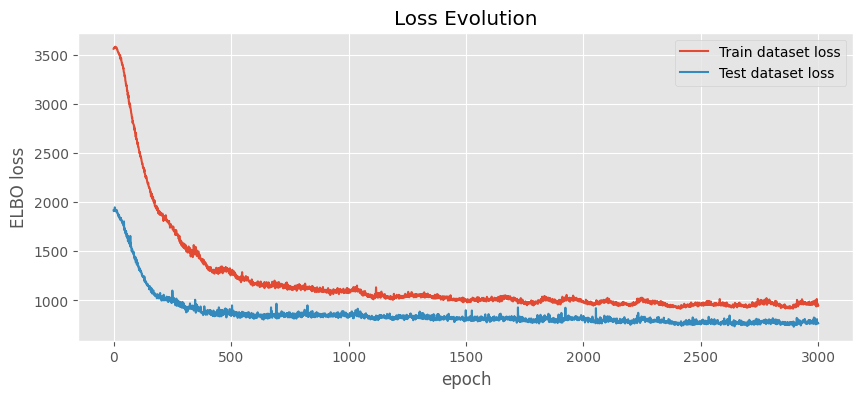

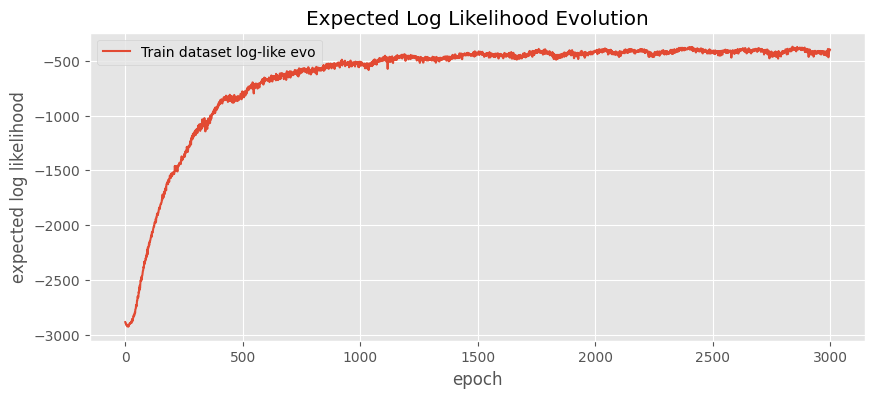

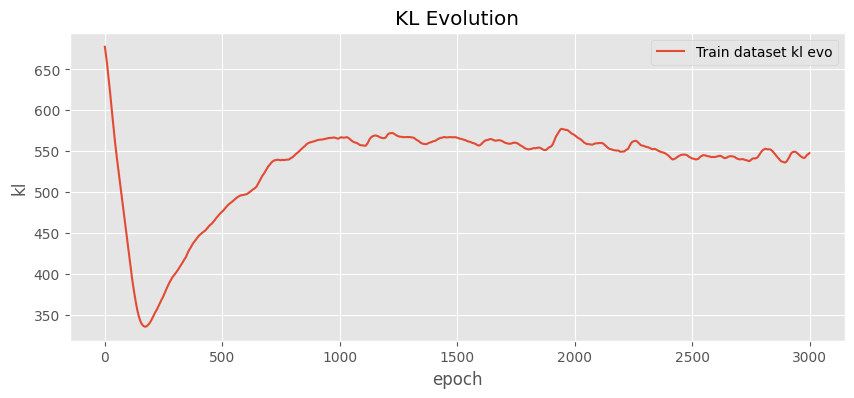

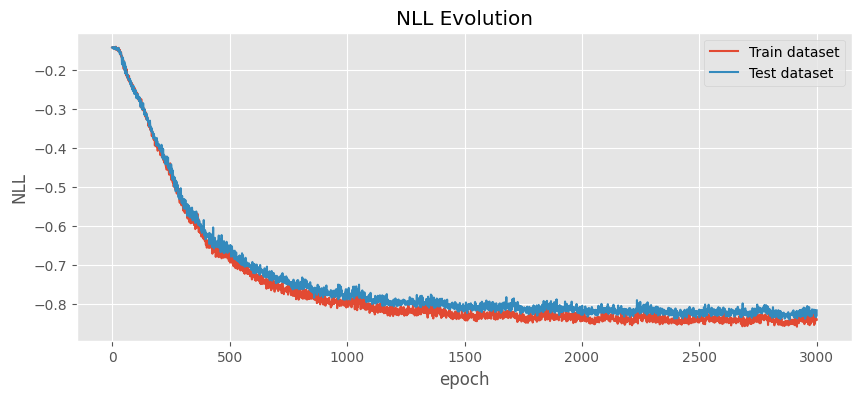

In [21]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_nll_loss_evo = []
te_nll_loss_evo = []
aux_loss = nn.NLLLoss()

for epoch in tqdm(range(3000)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_tr, y_tr, num_samples = 100)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_nll_loss_evo.append(aux_loss(bnn_model(x_tr,num_samples=10)[0].mean(0), y_tr).item())

    te_loss_evo.append(bnn_model.loss(x_te, y_te, num_samples = 10)[0].item())
    te_nll_loss_evo.append(aux_loss(bnn_model(x_te,num_samples=10)[0].mean(0), y_te).item())

    l.backward()
    opt.step()
    

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_nll_loss_evo, label='Train dataset')
plt.plot(te_nll_loss_evo, label='Test dataset')
plt.ylabel('NLL')
plt.xlabel('epoch')
plt.legend()
plt.title('NLL Evolution')
plt.show()

In [22]:
preds = bnn_model(x_te,1000)[0]
mean_preds = preds.mean(0)

In [23]:
loss = nn.NLLLoss()
loss(torch.log(mean_preds),y_te)

tensor(0.2338, grad_fn=<NllLossBackward0>)

In [24]:
indices = mean_preds.argmax(dim=1)
indices[:10]

tensor([0, 4, 0, 0, 5, 0, 3, 5, 2, 0])

In [25]:
y_te[:10]

tensor([0, 4, 0, 0, 1, 0, 3, 5, 2, 0])

In [26]:
accuracy = np.mean(np.array(indices) == np.array(y_te))
accuracy

np.float64(0.9321766561514195)

In [72]:
bnn_model.network[0].mu_q

Parameter containing:
tensor([-3.2299e-02, -8.5071e-03, -4.3256e-02, -1.8664e-01, -3.7080e-02,
        -4.7215e-01, -1.9633e-01, -1.5093e-01, -1.9622e-01, -3.5978e-01,
        -5.5346e-04, -3.6161e-03, -9.4387e-17,  1.0729e-15,  2.5368e-07,
        -6.6807e-07, -9.4167e-03,  2.6774e-10, -1.5978e-18, -6.5171e-09,
        -2.1822e-01, -2.2870e-01, -6.6202e-01, -1.1006e+00, -5.6345e-01,
        -1.3579e+00, -1.0931e+00, -9.8062e-01, -1.1539e+00, -1.3337e+00,
        -2.5782e-03, -6.3744e-03, -9.8576e-17,  6.5985e-10,  1.1238e-07,
        -3.8531e-05, -8.5491e-03, -9.3149e-07, -4.9035e-11, -1.9131e-05,
        -4.7527e-03, -5.0829e-03, -2.8563e-15,  4.4836e-09, -2.6762e-07,
        -1.1925e-04, -9.0433e-03, -2.7106e-06, -1.0271e-09, -4.2346e-05,
        -6.9768e-04, -4.7195e-03, -1.4834e-16,  5.2507e-13,  4.2437e-07,
        -8.3628e-06, -8.7657e-03, -9.9521e-09, -3.1414e-14, -6.6340e-07,
        -2.8045e-04,  5.6692e-04,  5.1838e-17, -8.0831e-17, -2.2567e-07,
         1.4958e-10, -8.2877e

In [106]:
bnn_model.network[4].chol_q

Parameter containing:
tensor([[-1.2293e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.1229e-02, -1.0863e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.8669e-03,  1.0197e-03, -1.1707e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 3.7095e-04,  1.6747e-03,  6.9361e-03,  ..., -2.5135e+00,
          0.0000e+00,  0.0000e+00],
        [-3.1583e-03,  2.5103e-03, -3.0569e-03,  ...,  1.9066e-02,
         -2.5019e+00,  0.0000e+00],
        [-1.4950e-04,  1.6135e-03, -3.3732e-03,  ...,  8.5649e-03,
          6.3635e-03, -2.5151e+00]], requires_grad=True)

In [ ]:
torch.Size([10, 634, 7])
